The AB test is a randomized experiment that is used by most large companies to evaluate the launch of new functionality. Various difficulties may arise in the analysis and conduct of the experiment. Several typical problematic cases from real life are given in this dataset and analysis.

### Content
1. [Loading and processing data](#Loading)
2. [Statistical Analysis](#Statistical)
3. [Conclusions](#Conclusions)

### Loading and processing data <a name="Loading"/>

Let's import the necessary libraries and load the data

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import mannwhitneyu
from scipy.stats import ttest_ind
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import seaborn as sns
from scipy.stats import pearsonr
from scipy.stats import shapiro

c:\Users\d1411\anaconda3\envs\JUPYTER_DEFAULT\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
# TODO : import the dataset
!kaggle datasets download -d sergylog/ab-test-data --unzip

Dataset URL: https://www.kaggle.com/datasets/sergylog/ab-test-data
License(s): Community Data License Agreement - Sharing - Version 1.0




  0%|          | 0.00/28.3k [00:00<?, ?B/s]
100%|██████████| 28.3k/28.3k [00:00<00:00, 465kB/s]


In [9]:
# TODO : take a quick look at the data
data = pd.read_csv('AB_Test_Results.csv')
data.head()

,USER_ID,VARIANT_NAME,REVENUE
0,737,variant,0.0
1,2423,control,0.0
2,9411,control,0.0
3,7311,control,0.0
4,6174,variant,0.0


In [14]:
data['REVENUE'].describe()

count    10000.000000
mean         0.099447
std          2.318529
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max        196.010000
Name: REVENUE, dtype: float64

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   USER_ID       10000 non-null  int64  
 1   VARIANT_NAME  10000 non-null  object 
 2   REVENUE       10000 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 234.5+ KB


In [13]:
data['USER_ID'].nunique()

6324

In [15]:
data['VARIANT_NAME'].value_counts()

VARIANT_NAME
variant    5016
control    4984
Name: count, dtype: int64

Let's see if there are users who have two A/B test groups

In [20]:
# TODO : Look at the distribution of the number of unique groups for each user
df = data.groupby('USER_ID')['VARIANT_NAME'].nunique().sort_values(ascending=False)
df


USER_ID
4967    2
4615    2
4586    2
4593    2
4595    2
       ..
1278    1
4678    1
4677    1
4670    1
2       1
Name: VARIANT_NAME, Length: 6324, dtype: int64

In [21]:
# How many users have seen both variants?
df[df == 2].shape[0]

1541

In [25]:
# TODO : Look at the distribution of the number of unique groups for each user in relative terms
data.groupby('USER_ID')['VARIANT_NAME'].nunique().value_counts(normalize=True)

VARIANT_NAME
1    0.756325
2    0.243675
Name: proportion, dtype: float64

What can you observe ? Should we exclude these users ? Why ?

In [26]:
# TODO : users have 1 A/B test group ?


# TODO : Take only these users


0.7563251106894371

In [ ]:
# TODO : Leave only records with users with the 1st ab test group

# TODO : Check that the number of users matches what it was before the exception


Let's see how the data is distributed

<Axes: xlabel='REVENUE'>

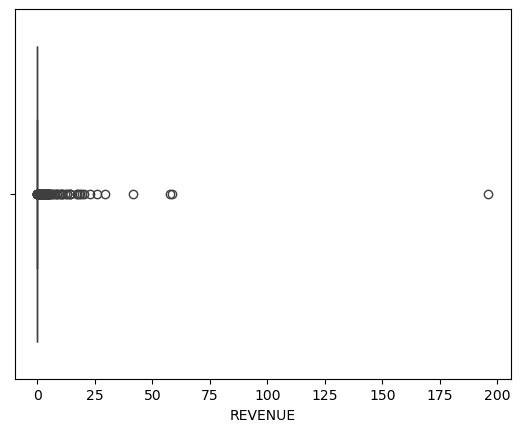

In [27]:
# TODO : Check how the data is distributed using a box plot
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(data=data, x='REVENUE')

It can be seen that there is a strong outlier in the data - we will find it by sorting these revenue values in descending order

In [31]:
# TODO : Sort these revenue values in descending order
data.sort_values(ascending=False, by='REVENUE').head(10)

,USER_ID,VARIANT_NAME,REVENUE
1437,3342,control,196.01
6447,2881,variant,58.63
7642,7206,variant,57.46
9421,6792,control,41.53
8168,2166,control,29.32
9125,831,control,25.98
2482,7356,variant,23.04
6412,1053,control,20.07
5217,3684,variant,19.47
5530,282,control,18.56


In [30]:
# TODO : See if user 3342 had other events with a strong outlier
data[data['USER_ID'] == 3342]

,USER_ID,VARIANT_NAME,REVENUE
1437,3342,control,196.01


We see that there is only one outlier - in conditions of limited information, we will remove this entry and look at the distribution of data again

<Axes: xlabel='REVENUE'>

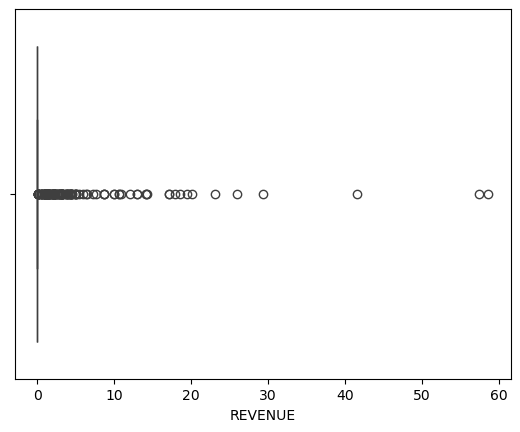

In [32]:
# TODO : We see that there is only one outlier - in conditions of limited information, remove this entry and visualize the distribution of data again.

data_cleared = data.drop(index=1437)

sns.boxplot(data=data_cleared, x='REVENUE')


What can you say about the users and their purchases ?

In [38]:
# TODO : Check if there are users who have records with zero and positive revenue
revenues = data_cleared.groupby('USER_ID')['REVENUE'].agg(['min', 'max'])
revenues

,min,max
USER_ID,,
2,0.0,0.00
3,0.0,0.00
4,0.0,0.00
5,0.0,0.00
6,0.0,0.00
...,...,...
9993,0.0,0.00
9995,0.0,0.00
9996,0.0,6.46


In [40]:
revenues['dif'] = revenues['max'] - revenues['min']
revenues.sort_values(by='dif', ascending=False).query('dif > 0')

,min,max,dif
USER_ID,,,
2881,0.0,58.63,58.63
7206,0.0,57.46,57.46
6792,0.0,41.53,41.53
2166,0.0,29.32,29.32
831,0.0,25.98,25.98
...,...,...,...
8927,0.0,0.06,0.06
6207,0.0,0.04,0.04
2182,0.0,0.04,0.04


Can a user have records with both zero and positive revenue ?

Let's make the assumption that the records are user visits to the service, and the experimental unit is users.


In [42]:
# TODO : Group the data for each user and sum the revenue for each to get one record per user
data_grouped = data_cleared.groupby('USER_ID')['REVENUE'].sum()
data_grouped

USER_ID
2        0.00
3        0.00
4        0.00
5        0.00
6        0.00
         ... 
9993     0.00
9995     0.00
9996     6.46
9998     0.00
10000    0.00
Name: REVENUE, Length: 6323, dtype: float64

(count    10000.000000
 mean         0.099447
 std          2.318529
 min          0.000000
 25%          0.000000
 50%          0.000000
 75%          0.000000
 max        196.010000
 Name: REVENUE, dtype: float64,
 count    6323.000000
 mean        0.126279
 std         1.557557
 min         0.000000
 25%         0.000000
 50%         0.000000
 75%         0.000000
 max        58.630000
 Name: REVENUE, dtype: float64)

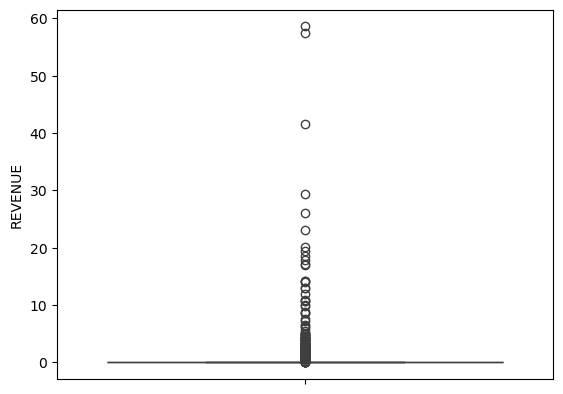

In [49]:
# TODO : Visualize the resulting distribution of the data again.
sns.boxplot(data=data_grouped)

data['REVENUE'].describe(), data_grouped.describe()

It should be noted that during the transformation, the quantiles in the test group increased

It can be seen that in the test group, almost all quantile statistics, except for the minimum, are at a slightly lower level.

Let's look at various statistics in the context of AB test groups for all users

In [57]:
# TODO : get metrics by groups


data_grouped1 = data_cleared.groupby('VARIANT_NAME')['REVENUE'].agg(['mean', 'median', 'std', 'count'])
display(data_grouped1)

# TODO : create two additional metrics to see relative changes
data_grouped2 = data.groupby('VARIANT_NAME')['REVENUE'].agg(['mean', 'median', 'std', 'count'])
display(data_grouped2)

data_grouped_diff = data_grouped2 - data_grouped1
display(data_grouped_diff)

# TODO : add them to the rest of the metrics in a separate group


,mean,median,std,count
VARIANT_NAME,,,,
control,0.089703,0.0,1.159256,4983
variant,0.070070,0.0,1.314802,5016


,mean,median,std,count
VARIANT_NAME,,,,
control,0.129013,0.0,3.007524,4984
variant,0.070070,0.0,1.314802,5016


,mean,median,std,count
VARIANT_NAME,,,,
control,0.03931,0.0,1.848269,1
variant,0.00000,0.0,0.000000,0


What can you see in the test group about the total amount of revenue, the average check per user, and the number of orders per user slightly increased ?

Let's also see how paying users behave :

In [ ]:
# TODO : get metrics by groups



# TODO : create two additional metrics to see relative changes


# TODO : add them to the rest of the metrics in a separate group


Let's look at the distributions of all and only paying users

C:\Users\d1411\AppData\Local\Temp\ipykernel_23100\160310950.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df.loc[df['VARIANT_NAME'] == 'control', 'REVENUE'], ax = axes[0], label='control')
C:\Users\d1411\AppData\Local\Temp\ipykernel_23100\160310950.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sn

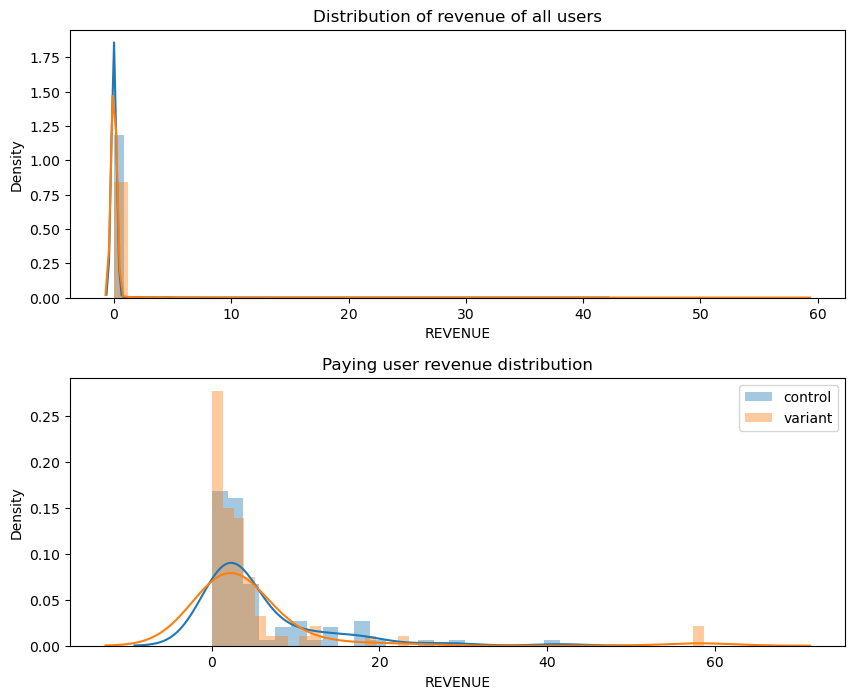

In [59]:
df = data_cleared
f, axes = plt.subplots(2, figsize=(10,8))
# build graphs of distributions of all users
sns.distplot(df.loc[df['VARIANT_NAME'] == 'control', 'REVENUE'], ax = axes[0], label='control')
sns.distplot(df.loc[df['VARIANT_NAME'] == 'variant', 'REVENUE'], ax = axes[0], label='variant')
axes[0].set_title('Distribution of revenue of all users')

# build graphs of distributions of paying users
sns.distplot(df.loc[(df['VARIANT_NAME'] == 'control') & (df['REVENUE'] > 0), 'REVENUE'], ax = axes[1], label='control' )
sns.distplot(df.loc[(df['VARIANT_NAME'] == 'variant') & (df['REVENUE'] > 0), 'REVENUE'], ax = axes[1], label='variant' )
axes[1].set_title('Paying user revenue distribution')
plt.legend()
plt.subplots_adjust(hspace = 0.3)

### Statistical Analysis <a name="Statistical"/>

#### Checking if the distribution is normal

Based on their previous graph, we see that the data is not normally distributed.

In [60]:
# TODO : Use the Shapiro-Wilk criterion to confirm it
shapiro(df.loc[df['VARIANT_NAME'] == 'control', 'REVENUE']), shapiro(df.loc[df['VARIANT_NAME'] == 'variant', 'REVENUE'])

c:\Users\d1411\anaconda3\envs\JUPYTER_DEFAULT\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 5016.
  res = hypotest_fun_out(*samples, **kwds)


(ShapiroResult(statistic=0.05089573515075019, pvalue=1.5781582594792284e-94),
 ShapiroResult(statistic=0.027033073451830147, pvalue=2.7310104028899288e-95))

Is the null hypothesis about the normal distribution of the data rejected ?

P-value is extremely small, we reject the null hypothesis

#### Mann-Whitney test

Let's check the value of the statistics of the Mann-Whitney test. Some sources have a limitation of applicability in case of duplicate data. There are a lot of repetitions in our sample, and especially a lot of zero values, so in this case we need to be careful about this criterion.

In [62]:
(df['REVENUE'] == 0).value_counts()

REVENUE
True     9848
False     151
Name: count, dtype: int64

In [63]:
# TODO : Check on the data of all users the value of the statistics of the Mann-Whitney test
mannwhitneyu(df.loc[df['VARIANT_NAME'] == 'control', 'REVENUE'], df.loc[df['VARIANT_NAME'] == 'variant', 'REVENUE'])

MannwhitneyuResult(statistic=12516548.0, pvalue=0.5291970335120277)

P-value is large and we cannot reject the null hypothesis. There is no statistically significant difference between the distributions of the two groups 

In [64]:
# TODO : Check on the data of only the users that pay, the value of the statistics of the Mann-Whitney test
mannwhitneyu(df.loc[(df['VARIANT_NAME'] == 'control') & (df['REVENUE'] > 0), 'REVENUE'], df.loc[(df['VARIANT_NAME'] == 'variant') & (df['REVENUE'] > 0), 'REVENUE'])

MannwhitneyuResult(statistic=3284.0, pvalue=0.10145877111519161)

P-value is much lower, but still exceed standard alpha level of 0.05. There's approximately a 10.1% chance that the observed differences between the groups are due to random variation

#### Bootstrap

In order to get more complete information about the differences between the average values of the ab test groups, we will use bootstap.

Let's create a function to get back samples and get a confidence interval, and then look at the sample statistics

In [68]:
def get_bootstrap_samples(data, n_samples=1000):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

def stat_intervals(stat, alpha=0.05):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

In [73]:
# TODO : Generate samples for all users

control_all = df.loc[df['VARIANT_NAME'] == 'control', 'REVENUE'].values
variant_all = df.loc[df['VARIANT_NAME'] == 'variant', 'REVENUE'].values

# Generate bootstrap samples for control and variant groups
n_bootstrap_samples = 1000
bootstrap_samples_control_all = get_bootstrap_samples(control_all, n_samples=n_bootstrap_samples)
bootstrap_samples_variant_all = get_bootstrap_samples(variant_all, n_samples=n_bootstrap_samples)

# Compute means for each bootstrap sample
control_means_all = np.mean(bootstrap_samples_control_all, axis=1)
variant_means_all = np.mean(bootstrap_samples_variant_all, axis=1)

# Calculate the difference in means for each bootstrap sample
mean_diffs_all = variant_means_all - control_means_all

# Calculate the 95% confidence interval for the difference in means
confidence_interval_all = stat_intervals(mean_diffs_all, alpha=0.05)

# Output the results
print(f"Mean difference between variant and control: {np.mean(mean_diffs_all)}")
print(f"95% Confidence Interval for the mean difference: {confidence_interval}")



Mean difference between variant and control: -0.019336727452285138
95% Confidence Interval for the mean difference: [-0.06467591  0.02942   ]


In [74]:
# TODO : Generate samples for only paying users

control_pay = df.loc[(df['VARIANT_NAME'] == 'control') & (df['REVENUE'] > 0), 'REVENUE'].values
variant_pay = df.loc[(df['VARIANT_NAME'] == 'variant') & (df['REVENUE'] > 0), 'REVENUE'].values

# Generate bootstrap samples for control and variant groups (only for REVENUE > 0)
n_bootstrap_samples = 1000
bootstrap_samples_control_pay = get_bootstrap_samples(control_pay, n_samples=n_bootstrap_samples)
bootstrap_samples_variant_pay = get_bootstrap_samples(variant_pay, n_samples=n_bootstrap_samples)

# Compute means for each bootstrap sample
control_means_pay = np.mean(bootstrap_samples_control_pay, axis=1)
variant_means_pay = np.mean(bootstrap_samples_variant_pay, axis=1)

# Calculate the difference in means for each bootstrap sample
mean_diffs_pay = variant_means_pay - control_means_pay

# Calculate the 95% confidence interval for the difference in means
confidence_interval_pay = stat_intervals(mean_diffs_pay, alpha=0.05)

# Output the results
print(f"Mean difference between variant and control (REVENUE > 0): {np.mean(mean_diffs_pay)}")
print(f"95% Confidence Interval for the mean difference (REVENUE > 0): {confidence_interval_pay}")

Mean difference between variant and control (REVENUE > 0): -0.7372174384669481
95% Confidence Interval for the mean difference (REVENUE > 0): [-3.46048207  2.29791399]


Let's look at the distribution of means in the ab test groups

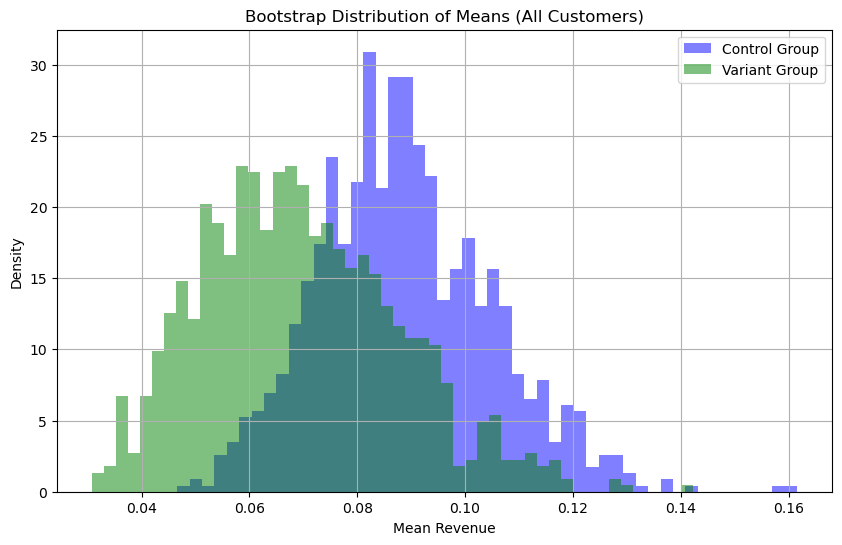

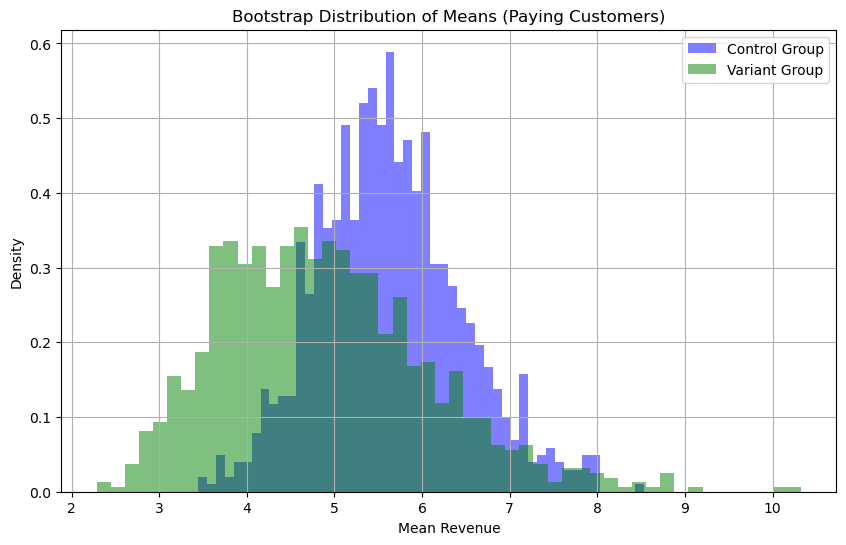

In [75]:
# Function to plot bootstrap results
def plot_bootstrap_results(control_means, variant_means, title):
    plt.figure(figsize=(10, 6))
    
    # Plot control group means
    plt.hist(control_means, bins=50, alpha=0.5, label='Control Group', color='blue', density=True)
    
    # Plot variant group means
    plt.hist(variant_means, bins=50, alpha=0.5, label='Variant Group', color='green', density=True)
    
    # Add labels and title
    plt.title(title)
    plt.xlabel('Mean Revenue')
    plt.ylabel('Density')
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.show()

# Plot for all users
plot_bootstrap_results(control_means_all, variant_means_all, 'Bootstrap Distribution of Means (All Customers)')


# Plot for paying customers
plot_bootstrap_results(control_means_pay, variant_means_pay, 'Bootstrap Distribution of Means (Paying Customers)')

Do you see any difference ? What about the confidence intervals ? Conclude.

- For both all customers and paying customers, the results of the bootstrap analysis suggest that the observed differences in mean revenue between the variant and control groups are not statistically significant. The confidence intervals for both groups include zero, meaning the differences are likely due to random chance, and there is no conclusive evidence that the variant either improves or worsens revenue outcomes compared to the control.

Let's evaluate the difference between the groups: look at the distribution of the mean difference and build confidence intervals for it. To do this, we will create a function for visualization

In [76]:
def plot_distribution_and_stat_intervals(variant, control, title, alpha=0.05):
    """ Plot the distribution of the mean difference and return the confidence intervals """
    f, ax = plt.subplots()
    # get data for coloring confidence intervals
    points = sns.kdeplot(variant - control, shade=True).get_lines()[0].get_data()
    x = points[0]
    y = points[1]
    ymin, ymax = plt.ylim()
    # highlight the zero value and the bounds of the confidence interval
    plt.vlines(0, 0, ymax, label='0', color='gray')
    plt.vlines(stat_intervals(variant - control, alpha)[0], 0, ymax, linestyles="dashed")
    plt.vlines(stat_intervals(variant - control, alpha)[1], 0, ymax, linestyles="dashed")
    # color the confidence interval and zones outside it
    plt.fill_between(x,y,
                     where = (x >= stat_intervals(variant - control, alpha)[1]),
                     color='gainsboro')
    plt.fill_between(x,y,
                     where = (x <= stat_intervals(variant - control, alpha)[0]),
                     color='gainsboro')
    plt.fill_between(x,y,
                     where = ((x >= stat_intervals(variant - control, alpha)[0])
                              & (x <= stat_intervals(variant - control, alpha)[1])),
                     color='red',
                     label = '95% confidence interval')
    plt.title(f'Distribution of difference between means (variant - control) {title}; {100*(1-alpha)}% Confidence interval for difference of means: {stat_intervals(variant - control, alpha)}')
    plt.legend(prop={'size':13})
    # return confidence interval data
    return stat_intervals(variant - control)

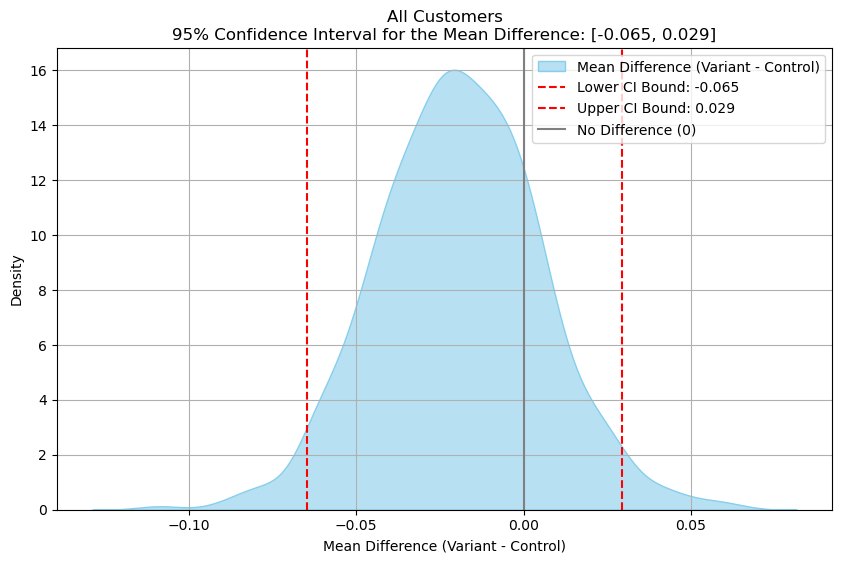

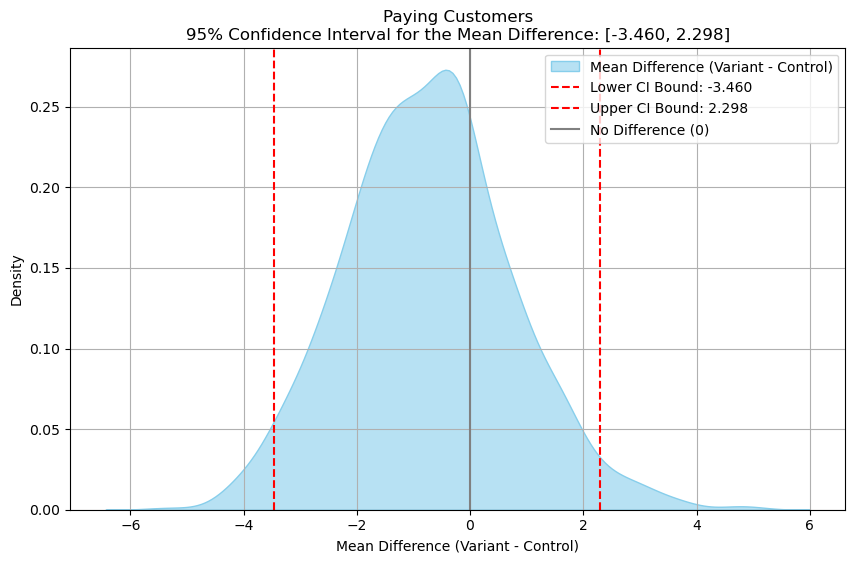

In [83]:
# Function to plot the distribution of mean difference and confidence intervals
def plot_distribution_and_stat_intervals(variant_means, control_means, title, alpha=0.05):
    """Plot the distribution of the mean difference and return the confidence intervals."""
    # Compute the mean differences
    mean_diff = variant_means - control_means
    
    # Calculate confidence intervals for the mean difference
    lower_bound, upper_bound = stat_intervals(mean_diff, alpha)
    
    # Plot the KDE distribution using Seaborn
    plt.figure(figsize=(10, 6))
    sns.kdeplot(mean_diff, fill=True, color="skyblue", label='Mean Difference (Variant - Control)', alpha=0.6)

    # Highlight the confidence interval
    plt.axvline(lower_bound, color='red', linestyle='--', label=f'Lower CI Bound: {lower_bound:.3f}')
    plt.axvline(upper_bound, color='red', linestyle='--', label=f'Upper CI Bound: {upper_bound:.3f}')
    
    # Highlight zero (no difference between groups)
    plt.axvline(0, color='gray', linestyle='-', label='No Difference (0)')

    # Set title and labels
    plt.title(f'{title}\n95% Confidence Interval for the Mean Difference: [{lower_bound:.3f}, {upper_bound:.3f}]')
    plt.xlabel('Mean Difference (Variant - Control)')
    plt.ylabel('Density')
    
    # Add legend
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return lower_bound, upper_bound

# Example usage:
# Assuming `variant_means` and `control_means` are already computed using bootstrap
ci_all_customers = plot_distribution_and_stat_intervals(variant_means_all, control_means_all, 'All Customers', alpha=0.05)
ci_paying_customers = plot_distribution_and_stat_intervals(variant_means_pay, control_means_pay, 'Paying Customers', alpha=0.05)

Let's build a graph of the distribution of the difference in the means and get a confidence interval

For all users

In [85]:
plot_distribution_and_stat_intervals(np.mean(variant, axis=1),
                                     np.mean(control, axis=1),
                                     title='all users')

AxisError: axis 1 is out of bounds for array of dimension 1

In [ ]:
plot_distribution_and_stat_intervals(np.mean(variant_paid, axis=1),
                                     np.mean(control_paid, axis=1),
                                     title='paying users')

What can you observe ? Conclude about the statistical change in average revenue between A/B test groups.
- As stated above there is no significant difference
